In [3]:
from datasets import build_dataset
import argparse
import opts
import sys
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd

In [5]:
# Jupyter Notebook이 전달하는 인자 제거
if 'ipykernel_launcher' in sys.argv[0]:
    sys.argv = sys.argv[:1]  # Jupyter 추가 인자를 제거

parser = argparse.ArgumentParser('ReferFormer training and evaluation script', parents=[opts.get_args_parser()])
args = parser.parse_args()

## 1. validation data 시각화

In [6]:
val_dataset = build_dataset('a2d', image_set = 'val', args = args)


 val sample num:  3800




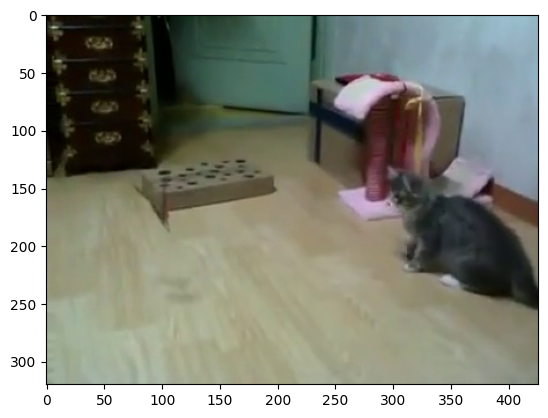

In [5]:
# 비디오 이미지들

plt.imshow(val_dataset[300][0][0].permute(1, 2, 0))
# print(train_dataset[1][0])

In [6]:
# 메타 정보 dictionary
# frames_idx, labels, boxes, masks, valid, caption, orig_size, size, area
print(val_dataset[300][1]['caption'])

a cat is jumping and playing with a toy


In [4]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

325


Button(description='Next image', style=ButtonStyle())

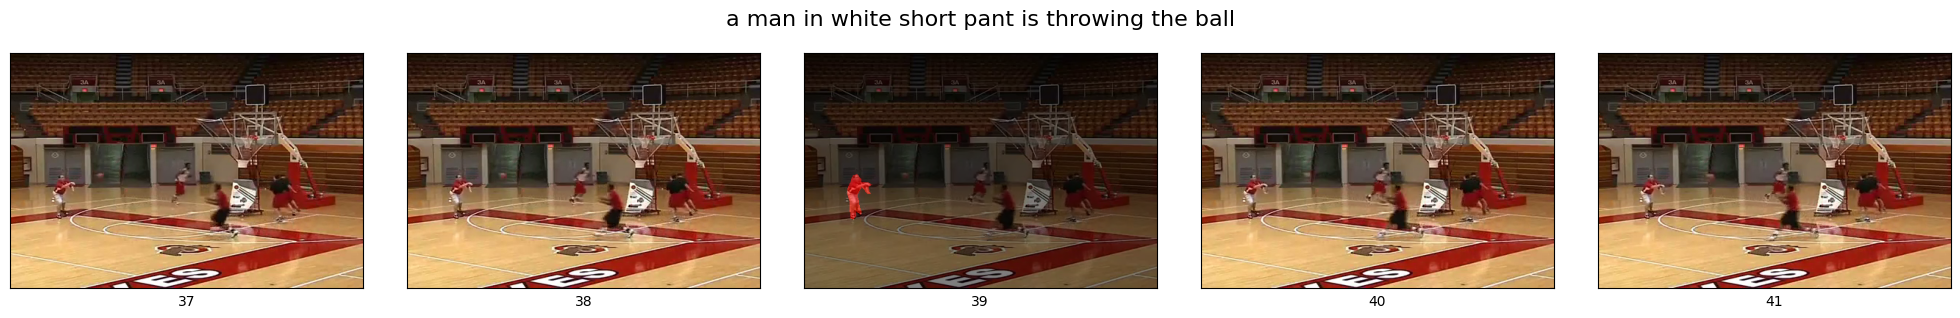

: 

In [ ]:
# 함수 정의
def review_images():
    index = 0
    prev_caption = ""

    def plot_image(i):
        nonlocal index
        nonlocal prev_caption

        print(index)

        if index < len(val_dataset):
            while prev_caption == val_dataset[index][1]['caption']:
                index +=1

            video = val_dataset[index]
            frames = video[0]
            frames_idx = video[1]['frames_idx']
            valid_idx = video[1]['valid_indices']
            valid_idx = valid_idx.item()
            masks = video[1]['masks']
            caption = video[1]['caption']

            if caption != prev_caption:
                num_frames = frames.shape[0]
                            
                fig = plt.figure(figsize = (20, 3))
                fig.suptitle(caption, fontsize = 16)
                    
                for i in range(num_frames):
                    ax = fig.add_subplot(1, num_frames, i+1)
                    plt.imshow(frames[i].permute(1, 2, 0))


                    if i == valid_idx:
                        mask_color = np.zeros((*masks[0].shape, 3), dtype = np.uint8)
                        mask_color[masks[0] == 1] = [255, 0, 0]
                        ax.imshow(mask_color, alpha = 0.5)

                    ax.set_xlabel(frames_idx[i].numpy())
                    ax.set_xticks([]), ax.set_yticks([])

                plt.tight_layout()

                prev_caption = caption

                index += 1
            

        else:
            print("No more images in the dataset")
            return
        
    # 버튼 클릭 시 호출될 함수
    def on_button_click(b):
        clear_output(wait= True)
        plot_image(index)
        if index < len(val_dataset):
            display(button)

    # 버튼 생성
    button = widgets.Button(description = "Next image")
    button.on_click(on_button_click)

    # 버튼 표시
    plot_image(index)
    display(button)

review_images()

## 2. expressions 살펴보기

In [ ]:
with open('/home/s1/yejinkim/projects/ReferFormer/data/ref-youtube-vos/meta_expressions/train/meta_expressions.json', 'r') as file:
    data = json.load(file)
    
train_expressions = []
videos = data['videos']

for video_id, video_val in videos.items():
    objects = video_val["expressions"]
    for _, object_val in objects.items():
        train_expressions.append(object_val['exp'])

In [177]:
with open('/home/s1/yejinkim/projects/ReferFormer/data/ref-youtube-vos/meta_expressions/valid/meta_expressions.json', 'r') as file:
    data = json.load(file)

valid_expressions = []
videos = data['videos']

for video_id, video_val in videos.items():
    objects = video_val["expressions"]
    for _, object_val in objects.items():
        valid_expressions.append(object_val['exp'])

In [178]:
with open('/home/s1/yejinkim/projects/ReferFormer/data/ref-youtube-vos/meta_expressions/test/meta_expressions.json', 'r') as file:
    data = json.load(file)

test_expressions = []
videos = data['videos']

for video_id, video_val in videos.items():
    objects = video_val["expressions"]
    for _, object_val in objects.items():
        test_expressions.append(object_val['exp'])

### 1) 동사

#### (1) 동사 뽑기

In [ ]:
#!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 17.6 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
verb_dict = {}

for i in range(len(train_expressions)):
    verb_list = []

    doc = nlp(train_expressions[i])
    for token in doc:
        if token.pos_ == 'VERB':
            verb_list.append(token.lemma_)
            
    verb_dict[i] = verb_list

#### (2) 동사 있는 경우 vs 없는 경우

In [142]:
yes_verb = 0
no_verb = 0

for _, val in verb_dict.items():
    if len(val) == 0:
        no_verb += 1
    else:
        yes_verb += 1

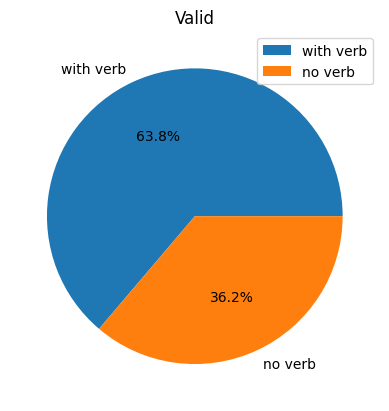

In [143]:
plt.pie([yes_verb, no_verb], labels = ["with verb", "no verb"], autopct='%1.1f%%')
plt.legend()
plt.title("Valid")
plt.show()

In [145]:
yes_verb

805

#### (3) 동사 개수

In [146]:
verb_count = {}
for _, verb_val in verb_dict.items():
    count = len(verb_val)
    if count not in verb_count:
        verb_count[count] = 1
    else:
        verb_count[count] += 1

In [147]:
verbCountKeys = list(verb_count.keys())
verbCountKeys.sort()

verb_count_sorted = {i: verb_count[i] for i in verbCountKeys}

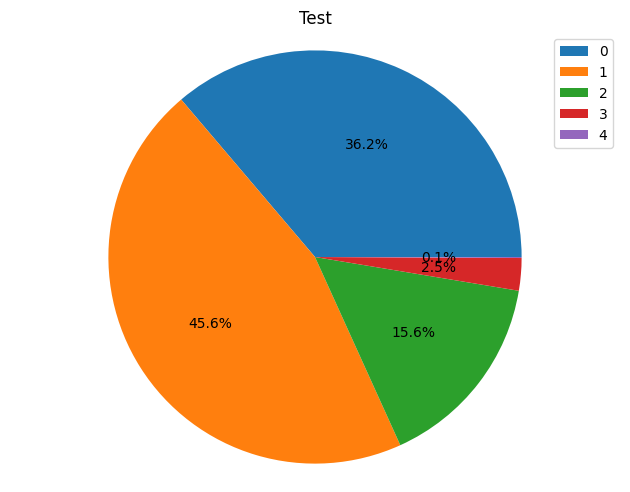

In [148]:
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(list(verb_count_sorted.values()), autopct = '%1.1f%%')
ax.legend(wedges, list(verb_count_sorted.keys()))
plt.axis('equal')
plt.tight_layout()
plt.title("Test")
plt.show()

In [149]:
verb_count_sorted

{0: 457, 1: 575, 2: 197, 3: 32, 4: 1}

#### (4) 동사 종류

In [135]:
all_verb_list = []
for verb_list in verb_dict.values():
    all_verb_list += verb_list

In [136]:
verb_types = pd.Series(all_verb_list).value_counts().sort_values(ascending = False)

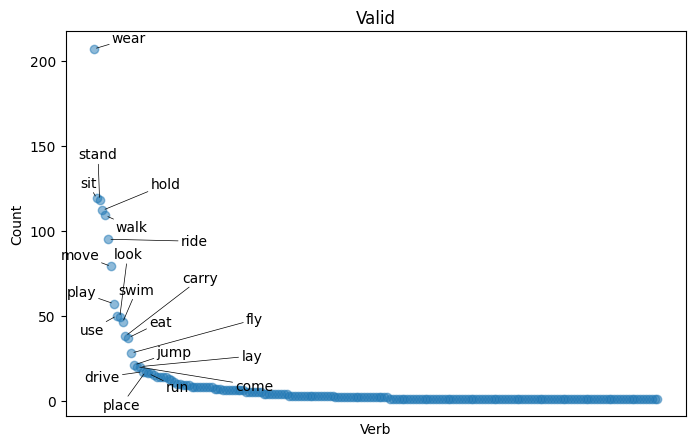

In [137]:
plt.figure(figsize=(8, 5))
plt.scatter(verb_types.index, verb_types.values, alpha = 0.5)
plt.xlabel('Verb')
plt.ylabel('Count')

texts = []
for i in range(20):
    texts.append(plt.text(verb_types.index[i], verb_types.values[i], verb_types.index[i]))

adjust_text(texts, only_move = {'points': 'y', 'texts': 'y'}, arrowprops=dict(arrowstyle='-', lw=0.5), expand = (2, 2))
plt.xticks([])
plt.title("Valid")
plt.show()

In [138]:
pd.DataFrame(verb_types[:20])

count
wear     207
sit      119
stand    118
hold     112
walk     109
ride      95
move      79
play      57
use       50
look      49
swim      46
carry     38
eat       37
fly       28
jump      21
come      20
lay       20
drive     17
place     17
run       16

### 2) 위치 표현

#### (1) 위치 뽑기

In [157]:
location_exps = [
    "left",
    "right",
    "front",
    "middle",
    "center",
    "back",
    "first",
    "ahead of",
    "last",
    "on the top",
    "below",
    "foreground",
    "background",
    "bottom",
    "top",
    "behind",
    "between"
]

In [183]:
location_dict = {}

for i in range(len(test_expressions)):
    location_list = []
    for location in location_exps:
        if location in test_expressions[i]:
            location_list.append(location)
    location_dict[i] = location_list

#### (2) 위치 있는 경우 vs 없는 경우

In [162]:
def plot_yes_no(dict, labels, split):
    yes = 0
    no = 0

    for _, val in dict.items():
        if len(val) == 0:
            no += 1
        else:
            yes += 1

    plt.pie([yes, no], labels = labels, autopct='%1.1f%%')
    plt.legend()
    plt.title(split)
    plt.show()

    print(f"yes: {yes}, no: {no}")

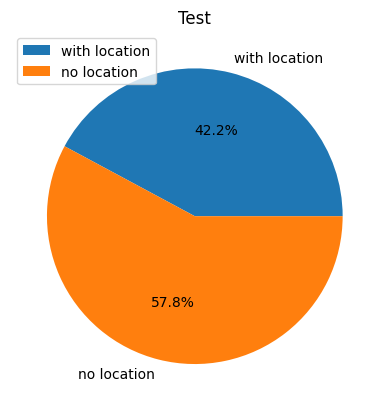

yes: 532, no: 730


In [184]:
plot_yes_no(location_dict, ["with location", "no location"], "Test")

#### (3) 위치 개수

In [164]:
def plot_count(dict, split):
    count_dict = {}
    for _, val in dict.items():
        count = len(val)
        if count not in count_dict:
            count_dict[count] = 1
        else:
            count_dict[count] += 1

    countKeys = list(count_dict.keys())
    countKeys.sort()

    count_dict_sorted = {i: count_dict[i] for i in countKeys}

    fig, ax = plt.subplots()
    wedges, texts, autotexts = ax.pie(list(count_dict_sorted.values()), autopct = '%1.1f%%')
    ax.legend(wedges, list(count_dict_sorted.keys()))
    plt.axis('equal')
    plt.tight_layout()
    plt.title(split)
    plt.show()

    print(count_dict_sorted)

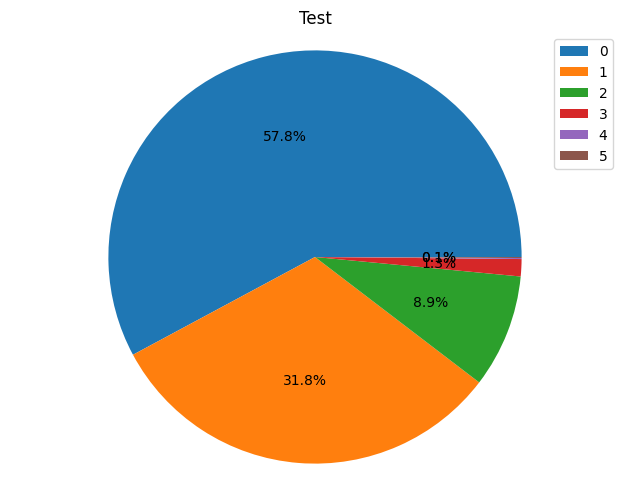

{0: 730, 1: 401, 2: 112, 3: 17, 4: 1, 5: 1}


In [185]:
plot_count(location_dict, "Test")

#### (4) 위치 종류

In [173]:
def plot_type(dict_name, xlabel, top_n, split):

    all_list = []
    for dict_list in dict_name.values():
        all_list += dict_list

    types = pd.Series(all_list).value_counts().sort_values(ascending = False)

    plt.figure(figsize=(8, 5))
    plt.scatter(types.index, types.values, alpha = 0.5)
    plt.xlabel(xlabel)
    plt.ylabel('Count')

    texts = []
    for i in range(top_n):
        texts.append(plt.text(types.index[i], types.values[i], types.index[i]))

    adjust_text(texts, only_move = {'points': 'y', 'texts': 'y'}, arrowprops=dict(arrowstyle='-', lw=0.5), expand = (2, 2))
    plt.xticks([])
    plt.title(split)
    plt.show()

    return pd.DataFrame(types[:top_n])

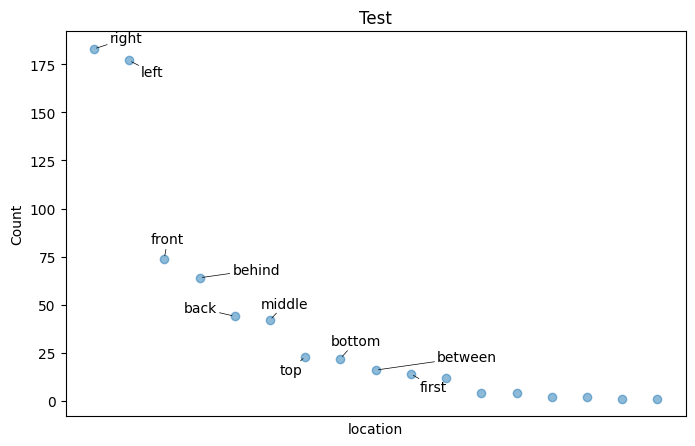

count
right      183
left       177
front       74
behind      64
back        44
middle      42
top         23
bottom      22
between     16
first       14

: 

In [ ]:
plot_type(location_dict, 'location', 10, 'Test')

# 3. 필터링